# Using PCA to test different modeling approaches

## What is Principal Component Analysis?
I'll try to dumb it down as much as I can but for the most part:
<br>PCA is reducing the dimensionality of your data set to make it easier to model. Pretty much you're turning your features (temp, wind speed, etc...) into components
<br>For example, let's say you have a painting that's mixed with a whole bunch of colors. What if you wanted to recreate that painting but you only have money to buy a few colors?
<br>PCA breaks down that painting into the core colors (components). This will let you recreate that picture with the limited amount of colors you have.
<br>Now in turn this will reduce how closely your painting looks to the original but if you use more components, the more it'll look like the original.
<br>So what we're trying to do is break down our dataset and make it easier to use. Instead of having those features like temp, wind speed, etc..., we'll have pc1, pc2, and so on
<br>Each principal component will explain less and less of the variance in data, so pc1 does the most and so on
<br><br>What does that mean for us?
<br>I comment as I code but pretty much, we have 11 features which isn't bad compared to the other groups but we could reduce it more if we changed them to principal components
<br>As you'll see later we dont get the luxury of only using 2 components because our data is very varied so we'll end up using 9 to get 90% of variance.
<br>That isn't really much but doing 8000x9 is still easier than 8000x11

### Importing

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

from sklearn.model_selection import train_test_split # for training a model
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], index_col='Date')
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough+

# Dropping features
df = df.drop(['Dew point temperature(C)', 'Holiday'], axis = 1)
    
# Converting Functioning Day to boolean
df['Functioning Day'] = df['Functioning Day'].apply(lambda x: x == 'Yes' or x is True)
    
# One-hot Encoding Seasons
df = pd.get_dummies(df, columns=['Seasons'], drop_first=True, prefix='', prefix_sep='')
    
# Converting booleans to integers
df = df.astype({col: int for col in df.select_dtypes('bool').columns})

display(df)

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day,Spring,Summer,Winter
Date,,,,,,,,,,,,,
2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,1,0,0,1
2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,1,0,0,1
2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,1,0,0,1
2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,1,0,0,1
2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-30,1003,19,4.2,34,2.6,1894,0.0,0.0,0.0,1,0,0,0
2018-11-30,764,20,3.4,37,2.3,2000,0.0,0.0,0.0,1,0,0,0
2018-11-30,694,21,2.6,39,0.3,1968,0.0,0.0,0.0,1,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler # for scaling data
from sklearn.preprocessing import PowerTransformer

y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

# normalizing our target variable
y_transformer = PowerTransformer('yeo-johnson')
y_train = y_transformer.fit_transform(y_train.reshape(-1, 1)).ravel() # ravel flattens arrays to 1D, some models like it this way
y_test = y_transformer.transform(y_test.reshape(-1, 1)).ravel()

# changing snowfall and rainfall to binary features
X_train['Rainfall_Binary'] = (X_train['Rainfall(mm)'] > 0).astype(int)
X_test['Rainfall_Binary'] = (X_test['Rainfall(mm)'] > 0).astype(int)
X_train['Snowfall_Binary'] = (X_train['Snowfall (cm)'] > 0).astype(int)
X_test['Snowfall_Binary'] = (X_test['Snowfall (cm)'] > 0).astype(int)
X_train = X_train.drop(['Rainfall(mm)', 'Snowfall (cm)'], axis=1)
X_test = X_test.drop(['Rainfall(mm)', 'Snowfall (cm)'], axis=1)

# Taking out our non-numerical values from the scaler
scale_columns = ['Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)']
no_scale = ['Functioning Day', 'Rainfall_Binary', 'Snowfall_Binary', 'Spring', 'Summer', 'Winter']

# Separating numerical data from the rest
no_scale_train = X_train[no_scale]
no_scale_test = X_test[no_scale]
train_to_scale = X_train[scale_columns]
test_to_scale = X_test[scale_columns]

# normalizing features skewed distributions (or at least attempting to)
sun_transformer = PowerTransformer('yeo-johnson')
train_to_scale.loc[:, 'Solar Radiation (MJ/m2)'] = sun_transformer.fit_transform(train_to_scale[['Solar Radiation (MJ/m2)']])
test_to_scale.loc[:, 'Solar Radiation (MJ/m2)'] = sun_transformer.transform(test_to_scale[['Solar Radiation (MJ/m2)']])

# standardizing all features
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(train_to_scale)
scaled_x_test = scaler.transform(test_to_scale)

# converting scaled data into dataframes to concat
scaled_x_train = pd.DataFrame(scaled_x_train, index=X_train.index, columns=train_to_scale.columns)
scaled_x_test = pd.DataFrame(scaled_x_test, index=X_test.index, columns=test_to_scale.columns)

# concating the non-numerical data with the numerical
X_train = pd.concat([scaled_x_train, no_scale_train], axis=1).to_numpy()
X_test = pd.concat([scaled_x_test, no_scale_test], axis=1).to_numpy()

## Setting up training and testing sets of data

 - `xtrain` is the proportion of data we want to use for training. We set `train_size = 0.7` which means we want 70% of our data to be used for training
 - `xtest` is the proportion of data we want to test against the training proportion. Since 70% of the data was used for training, only 30% is used for testing
 - `ytrain` is the proportion (70%) of target values (bike count) that matches the corresponding data. Each row in `xtrain` has a corresponding bike count in `ytrain`
 - `ytest` is the proportion of target values we want to test against the training portion. Like before, each row in `xtest` has a corresponding bike count in `ytest`

Pretty much we'll try to use `xtrain` and `ytrain` to predict what values will show up in `xtest` and `ytest`

## Applying Principal Component Analysis

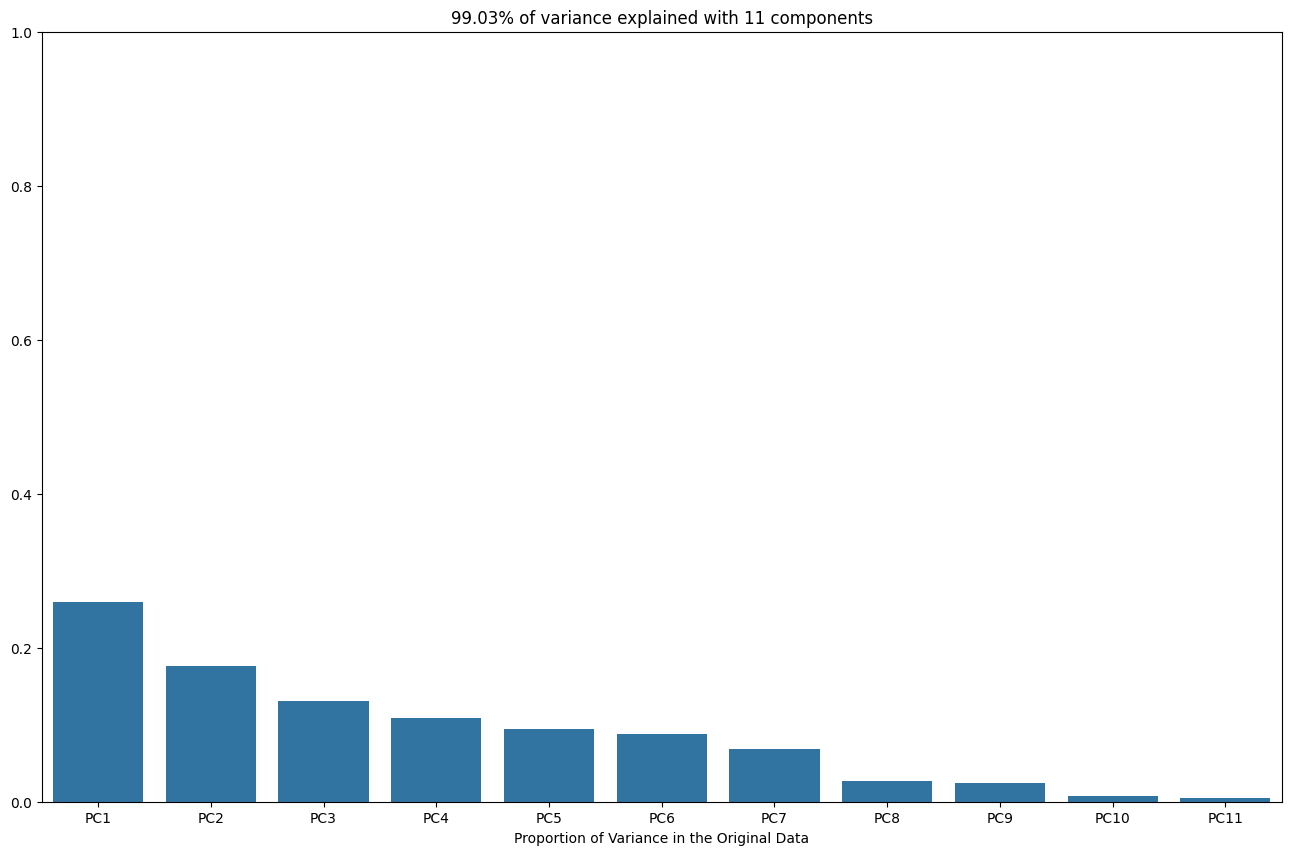

In [103]:
from sklearn.decomposition import PCA # dimension reduction

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
n_components = len(pca.components_)
plt.figure(figsize=(16,10))
sns.barplot(x=["PC" + str(i) for i in range(1, n_components + 1)], y=pca.explained_variance_ratio_)
plt.ylim(0,1)
plt.xlabel('Proportion of Variance in the Original Data')
plt.title(f'{sum(pca.explained_variance_ratio_)* 100:.2f}% of variance explained with {n_components} components')
plt.show()

Unfortunately, since PC1 and PC2 don't make up much of the variance, we have to use more components which make it impossible to visualize our data
<br>That being said, it's easier to work with 8000x11 than 8000x14

In [ ]:
pca_xtrain = pd.DataFrame(X_train_pca,  columns=["PC" + str(i) for i in range(1, n_components + 1)])
pca_xtest = pd.DataFrame(X_test_pca,  columns=["PC" + str(i) for i in range(1, n_components + 1)])
display(pca_xtrain.head())
display(pca_xtest.head())
# xtrain and xtest now have their respective pca counterparts

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,1.319778,1.634850,0.177172,0.574219,1.197747,0.035048,-0.441929,-0.513487,0.286158,0.225438,-0.120573
1,0.144898,1.273727,-0.980540,0.420522,0.043025,1.037696,0.185314,-0.235601,0.706841,0.289267,-0.023481
2,0.507319,0.185355,-1.438461,-0.003032,-0.775526,0.505316,1.093062,0.199518,-0.229189,-0.497541,0.233358
3,1.657003,-0.112323,1.141442,-0.129463,1.496104,-1.162994,-0.649341,-0.652583,0.508929,-0.077838,0.351630
4,1.778731,0.533182,0.648723,0.088687,1.176762,-0.782601,0.024933,-0.132832,0.646401,-0.366658,-0.192294


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,0.094370,0.554295,-0.866272,0.298368,-0.353866,0.296275,-0.363227,0.870070,0.393558,0.146167,0.271632
1,0.561807,1.023923,-0.808145,0.511466,-0.053537,0.431068,-0.416655,0.059763,0.485289,-0.452387,0.211460
2,-0.349448,0.700031,-0.112971,0.835891,-0.690431,-0.673962,-1.462074,0.585828,0.174904,0.162679,0.025893
3,0.966615,0.620917,-0.918206,0.080592,0.094562,0.507789,0.599370,0.162920,0.450855,-0.451324,0.216446
4,0.679991,-1.499702,-1.459200,-0.594231,-0.856789,0.251590,0.182467,-0.237463,0.384297,0.072653,0.302558


In [95]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import ARDRegression, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, LinearRegression
from sklearn.linear_model import QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, BayesianRidge
from sklearn.linear_model import TheilSenRegressor, TweedieRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,  HistGradientBoostingRegressor, RandomForestRegressor

### Linear Regression without PCA

In [105]:
linReg = LinearRegression()
y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))
linReg.fit(X_train, y_train_original)
print("Test Accuracy: {:.2f}%".format(linReg.score(X_test, y_test_original) * 100))

Test Accuracy: 56.93%


### Linear Regression with PCA

In [106]:
pca_linReg = LinearRegression()
y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))
pca_linReg.fit(pca_xtrain, y_train_original)
print("Test Accuracy with {} Components: {:.2f}%".format(n_components, pca_linReg.score(pca_xtest, y_test_original) * 100))

Test Accuracy with 11 Components: 47.88%


In [101]:
all_model = {
    'DecisionTree' : DecisionTreeRegressor(),
    'ExtraTree' : ExtraTreeRegressor(),
    'KNeighbors' : KNeighborsRegressor(),
    'KernelRidge' : KernelRidge(),
    'LinearSVR' : LinearSVR(),
    'NuSVR' : NuSVR(),
    'SVR' : SVR(),
    'ARDRegression' : ARDRegression(),
    'ElasticNet' : ElasticNet(),
    'ElasticNetCV' : ElasticNetCV(),
    'HuberRegressor' : HuberRegressor(),
    'Lars' : Lars(),
    'LarsCV' : LarsCV(),
    'Lasso' : Lasso(),
    'LassoCV' : LassoCV(),
    'LassoLarsCV' : LassoLarsCV(),
    'LassoLarsIC' : LassoLarsIC(),
    'LinearRegression' : LinearRegression(),
    'QuantileRegressor' : QuantileRegressor(),
    'RANSACRegressor' : RANSACRegressor(),
    'Ridge' : Ridge(),
    'RidgeCV' : RidgeCV(),
    'SGDRegressor' : SGDRegressor(),
    'BayesianRidge' : BayesianRidge(),
    'TheilSenRegressor' : TheilSenRegressor(),
    'TweedieRegressor' : TweedieRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(),
    'GradientBoostingRegressor' : GradientBoostingRegressor(),
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor' : XGBRegressor()
    }

screening = [] # our output

for name, model in all_model.items():
    print(name) # for debugging

    reg = model.fit(pca_xtrain, y_train)

    train_pred = reg.predict(pca_xtrain)
    test_pred = reg.predict(pca_xtest)

    pred_train_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    pred_test_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

    r2_train = round(r2_score(y_train_original, pred_train_original), 2)
    r2_test = round(r2_score(y_test_original, pred_test_original), 2)
    mse_train = round(mean_squared_error(y_train_original, pred_train_original), 2)
    mse_test = round(mean_squared_error(y_test_original, pred_test_original), 2)
    rmse = np.sqrt(mse_test)
    screening.append([name, r2_test, r2_train, mse_test, mse_train, rmse])

# converting output to a dataframe and adding column names
screening_df = pd.DataFrame(screening, columns=('model', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'rmse'))

# makes it easier to find overfitting, should be positive
screening_df['r2_diff'] = screening_df['r2_test'] - screening_df['r2_train']

# makes it easier to find overfitting, should be negative
screening_df['mse_diff'] = screening_df['mse_test'] - screening_df['mse_train']

clear_output(True) # clean up output
display(screening_df.sort_values(['r2_test', 'r2_diff'], ascending=False))

,model,r2_test,r2_train,mse_test,mse_train,rmse,r2_diff,mse_diff
26,ExtraTreesRegressor,0.82,1.00,73240.78,0.00,270.630338,-0.18,73240.78
29,RandomForestRegressor,0.81,0.97,78614.84,13482.94,280.383380,-0.16,65131.90
28,HistGradientBoostingRegressor,0.79,0.88,83924.58,52347.79,289.697394,-0.09,31576.79
30,XGBRegressor,0.79,0.95,85578.63,19085.53,292.538254,-0.16,66493.10
5,NuSVR,0.75,0.76,102714.80,100704.52,320.491498,-0.01,2010.28
6,SVR,0.75,0.76,102567.99,101195.19,320.262377,-0.01,1372.80
27,GradientBoostingRegressor,0.70,0.73,120117.05,112018.59,346.579067,-0.03,8098.46
2,KNeighbors,0.69,0.82,124413.33,75549.83,352.722738,-0.13,48863.50
0,DecisionTree,0.63,1.00,148455.13,0.00,385.298754,-0.37,148455.13
1,ExtraTree,0.56,1.00,179875.50,0.00,424.117319,-0.44,179875.50


### Results
If you look at our model file, I perform this exact same "everything under the sun" test on our data **without** PCA
<br>With PCA, everything just performs worse so there's no point in doing it
<br>The tradeoff between lower dimensionality and worse performance isn't worth the trouble